In [144]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras  #v. 2.9.0
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [145]:
#### --------------------------------------------   COMMENT IT WHEN USING DATABRICKS   ---------------------------------

data = pd.read_csv('CardiacPrediction_csv.csv')

In [146]:
#### --------------------------------------------   UNCOMMENT IT WHEN USING DATABRICKS   ---------------------------------
#Reading csv file in databricks

# # File location and type 
# file_location = "/FileStore/tables/CardiacPrediction_csv.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "false"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# display(df)

In [147]:
#### --------------------------------------------   UNCOMMENT IT WHEN USING DATABRICKS   ---------------------------------

#dataframe 'df' in spark is different than in pandas. I convert it and call it 'data'. 
# data = df.toPandas()
# print(data)

In [148]:
data.head()

,SEQN,Gender,Age,Annual-Family-Income,Ratio-Family-Income-Poverty,X60-sec-pulse,Systolic,Diastolic,Weight,Height,...,Total-Cholesterol,HDL,Glycohemoglobin,Vigorous-work,Moderate-work,Health-Insurance,Diabetes,Blood-Rel-Diabetes,Blood-Rel-Stroke,CoronaryHeartDisease
0,2,1,77,8,5.00,68,98,56,75.4,174.0,...,5.56,1.39,4.7,3,3,1,2,2,2,0
1,5,1,49,11,5.00,66,122,83,92.5,178.3,...,7.21,1.08,5.5,1,1,1,2,2,2,0
2,12,1,37,11,4.93,64,174,99,99.2,180.0,...,4.03,0.98,5.2,2,1,1,2,1,1,0
3,13,1,70,3,1.07,102,130,66,63.6,157.7,...,8.12,1.28,7.6,3,3,1,1,1,2,0
4,14,1,81,5,2.67,72,136,61,75.5,166.2,...,4.50,1.04,5.8,1,1,1,2,2,2,0


In [149]:
#dropping these features as mentioned in paper 'An efficient convolutional neural network for coronary heart disease prediction'
data.drop(['SEQN','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Glucose','Vigorous-work','Total-Cholesterol','CoronaryHeartDisease','Blood-Rel-Stroke','Red-Cell-Distribution-Width','Triglycerides','Mean-Platelet-Vol','Platelet-count','Lymphocyte','Monocyte','Eosinophils','Mean-cell-Hemoglobin','White-Blood-Cells','Red-Blood-Cells','Basophils','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [150]:
#data = data.astype(float)

In [151]:
data['Diabetes'].loc[(data['Diabetes'] == 3 )] = 1

C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_17936\3794381626.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [152]:
#adding a modification to consider 3 as 1 and only work with two classes

data["Diabetes"]==data["Diabetes"].replace([3],1)

0        True
1        True
2        True
3        True
4        True
         ... 
37074    True
37075    True
37076    True
37077    True
37078    True
Name: Diabetes, Length: 37079, dtype: bool

In [153]:
data["Diabetes"].value_counts()

2    32227
1     4852
Name: Diabetes, dtype: int64

In [154]:
data["Diabetes"].describe()

count    37079.000000
mean         1.869144
std          0.337247
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Diabetes, dtype: float64

In [155]:
#del data['Basophils']

In [156]:
#del data['Health-Insurance']

In [157]:
#del data['Platelet-count']

In [158]:
data.shape

(37079, 25)

In [159]:
data.columns

Index(['Gender', 'Age', 'Systolic', 'Diastolic', 'Weight', 'Body-Mass-Index',
       'Hemoglobin', 'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol',
       'Creatinine', 'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin',
       'Protein', 'Uric.Acid', 'HDL', 'Glycohemoglobin', 'Moderate-work',
       'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

In [160]:
data.isnull().sum()

Gender                0
Age                   0
Systolic              0
Diastolic             0
Weight                0
Body-Mass-Index       0
Hemoglobin            0
Albumin               0
ALP                   0
AST                   0
ALT                   0
Cholesterol           0
Creatinine            0
GGT                   0
Iron                  0
LDH                   0
Phosphorus            0
Bilirubin             0
Protein               0
Uric.Acid             0
HDL                   0
Glycohemoglobin       0
Moderate-work         0
Diabetes              0
Blood-Rel-Diabetes    0
dtype: int64

In [161]:
data.describe()

,Gender,Age,Systolic,Diastolic,Weight,Body-Mass-Index,Hemoglobin,Albumin,ALP,AST,...,LDH,Phosphorus,Bilirubin,Protein,Uric.Acid,HDL,Glycohemoglobin,Moderate-work,Diabetes,Blood-Rel-Diabetes
count,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,...,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000,37079.000000
mean,1.513282,48.943661,124.090078,69.919253,80.988276,28.824588,14.139073,42.528116,70.789611,25.722511,...,132.045632,1.203049,11.801173,72.050158,321.723326,1.370344,5.676496,1.598856,1.869144,1.549502
std,0.499830,18.010440,19.254741,13.575804,20.678734,6.608982,1.541599,3.585254,26.073559,19.695625,...,31.961662,0.182223,5.276652,4.967992,86.129723,0.415985,1.050223,0.511199,0.337247,0.497550
min,1.000000,20.000000,0.000000,0.000000,32.300000,13.180000,5.800000,19.000000,7.000000,7.000000,...,4.000000,0.484000,0.000000,47.000000,23.800000,0.160000,2.000000,1.000000,1.000000,1.000000
25%,1.000000,33.000000,111.000000,62.000000,66.500000,24.220000,13.100000,40.000000,55.000000,19.000000,...,113.000000,1.098000,8.550000,69.000000,261.700000,1.070000,5.200000,1.000000,2.000000,1.000000
50%,2.000000,48.000000,121.000000,70.000000,78.200000,27.800000,14.100000,43.000000,67.000000,23.000000,...,128.000000,1.195000,10.260000,72.000000,315.200000,1.290000,5.400000,2.000000,2.000000,2.000000
75%,2.000000,63.000000,134.000000,78.000000,92.100000,32.100000,15.200000,45.000000,82.000000,27.000000,...,146.000000,1.324000,13.680000,75.000000,374.700000,1.600000,5.800000,2.000000,2.000000,2.000000
max,2.000000,85.000000,270.000000,132.000000,371.000000,130.210000,19.700000,57.000000,729.000000,1672.000000,...,1539.000000,2.648000,224.010000,113.000000,1070.600000,5.840000,18.800000,3.000000,2.000000,2.000000


In [162]:
data.shape

(37079, 25)

In [163]:
data['Diabetes'].describe()

count    37079.000000
mean         1.869144
std          0.337247
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Diabetes, dtype: float64

In [164]:
data.columns

Index(['Gender', 'Age', 'Systolic', 'Diastolic', 'Weight', 'Body-Mass-Index',
       'Hemoglobin', 'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol',
       'Creatinine', 'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin',
       'Protein', 'Uric.Acid', 'HDL', 'Glycohemoglobin', 'Moderate-work',
       'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

<AxesSubplot:>

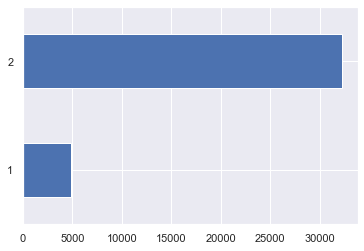

In [165]:
data["Diabetes"].value_counts().sort_index().plot.barh()


In [166]:
#data["Gender"].value_counts().sort_index().plot.barh()
#balanced

In [167]:
#data.corr()

In [168]:
data.columns

Index(['Gender', 'Age', 'Systolic', 'Diastolic', 'Weight', 'Body-Mass-Index',
       'Hemoglobin', 'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol',
       'Creatinine', 'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin',
       'Protein', 'Uric.Acid', 'HDL', 'Glycohemoglobin', 'Moderate-work',
       'Diabetes', 'Blood-Rel-Diabetes'],
      dtype='object')

In [169]:
data.shape

(37079, 25)

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              37079 non-null  int64  
 1   Age                 37079 non-null  int64  
 2   Systolic            37079 non-null  int64  
 3   Diastolic           37079 non-null  int64  
 4   Weight              37079 non-null  float64
 5   Body-Mass-Index     37079 non-null  float64
 6   Hemoglobin          37079 non-null  float64
 7   Albumin             37079 non-null  int64  
 8   ALP                 37079 non-null  int64  
 9   AST                 37079 non-null  int64  
 10  ALT                 37079 non-null  int64  
 11  Cholesterol         37079 non-null  float64
 12  Creatinine          37079 non-null  float64
 13  GGT                 37079 non-null  int64  
 14  Iron                37079 non-null  float64
 15  LDH                 37079 non-null  int64  
 16  Phos

In [171]:
data = data.astype(float)


In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              37079 non-null  float64
 1   Age                 37079 non-null  float64
 2   Systolic            37079 non-null  float64
 3   Diastolic           37079 non-null  float64
 4   Weight              37079 non-null  float64
 5   Body-Mass-Index     37079 non-null  float64
 6   Hemoglobin          37079 non-null  float64
 7   Albumin             37079 non-null  float64
 8   ALP                 37079 non-null  float64
 9   AST                 37079 non-null  float64
 10  ALT                 37079 non-null  float64
 11  Cholesterol         37079 non-null  float64
 12  Creatinine          37079 non-null  float64
 13  GGT                 37079 non-null  float64
 14  Iron                37079 non-null  float64
 15  LDH                 37079 non-null  float64
 16  Phos

<AxesSubplot:>

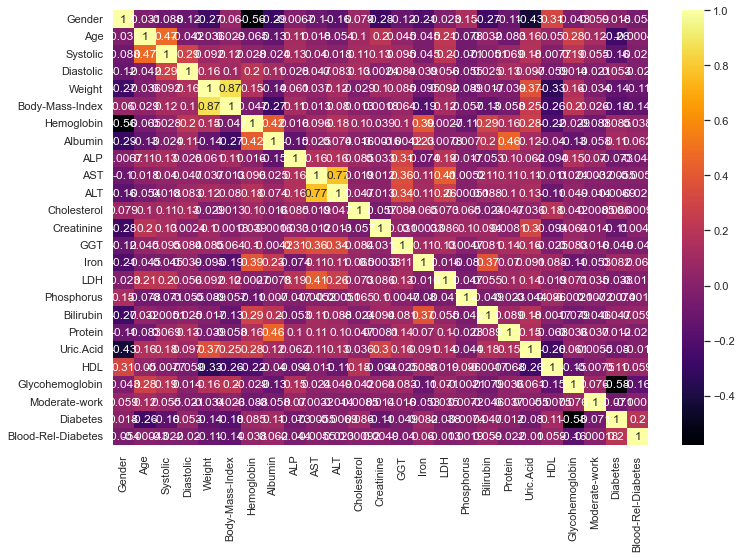

In [173]:
import seaborn as sns
plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(),cmap='inferno', annot=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Systolic'),
  Text(4, 0, 'Diastolic'),
  Text(5, 0, 'Weight'),
  Text(6, 0, 'Body-Mass-Index'),
  Text(7, 0, 'Hemoglobin'),
  Text(8, 0, 'Albumin'),
  Text(9, 0, 'ALP'),
  Text(10, 0, 'AST'),
  Text(11, 0, 'ALT'),
  Text(12, 0, 'Cholesterol'),
  Text(13, 0, 'Creatinine'),
  Text(14, 0, 'GGT'),
  Text(15, 0, 'Iron'),
  Text(16, 0, 'LDH'),
  Text(17, 0, 'Phosphorus'),
  Text(18, 0, 'Bilirubin'),
  Text(19, 0, 'Protein'),
  Text(20, 0, 'Uric.Acid'),
  Text(21, 0, 'HDL'),
  Text(22, 0, 'Glycohemoglobin'),
  Text(23, 0, 'Moderate-work'),
  Text(24, 0, 'Diabetes'),
  Text(25, 0, 'Blood-Rel-Diabetes')])

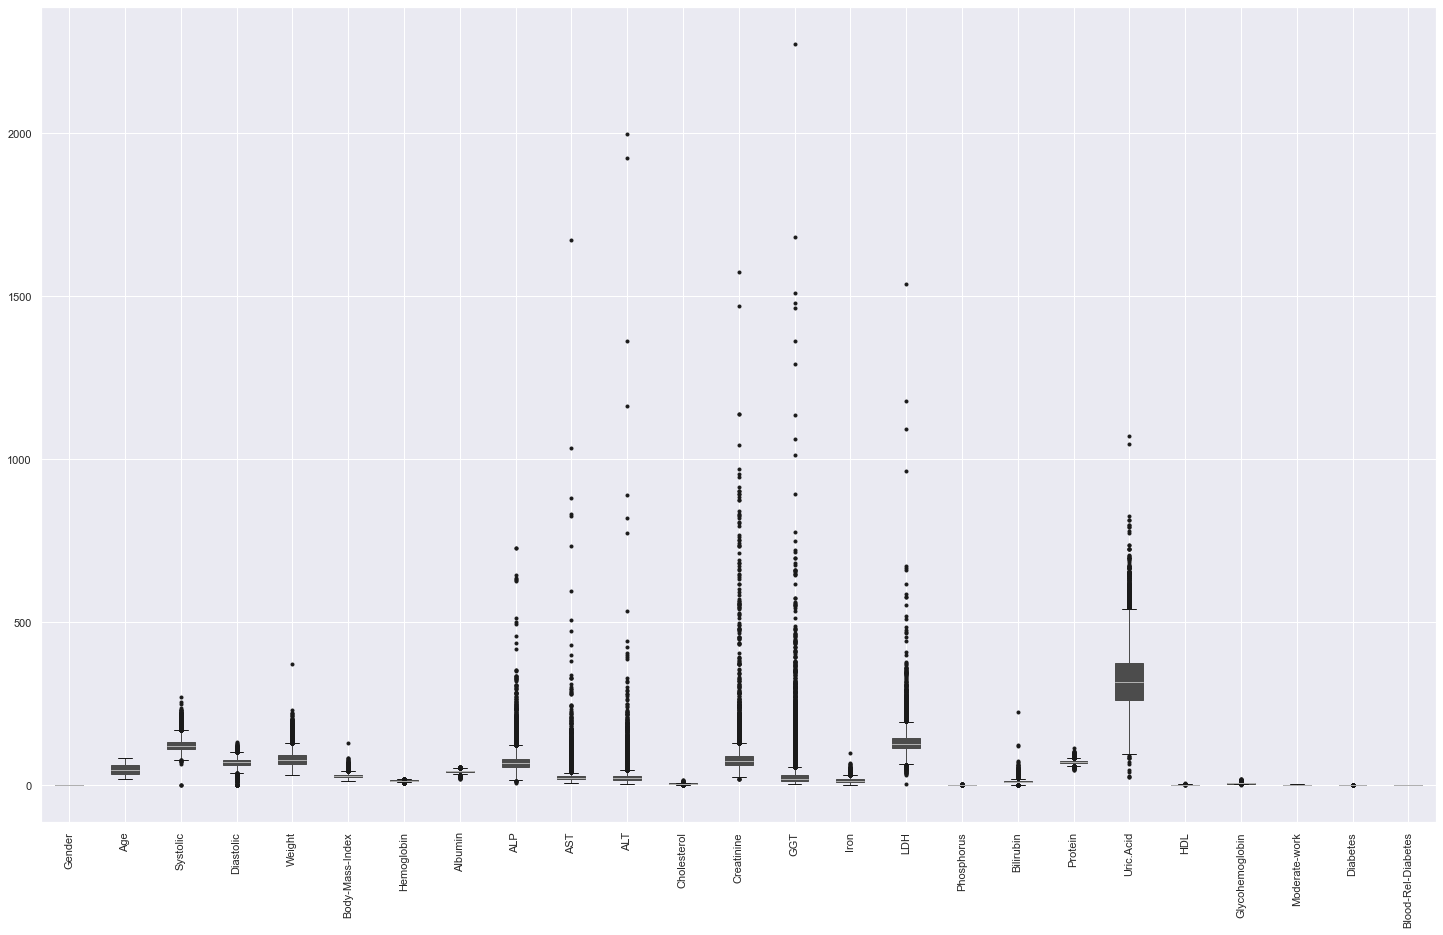

In [174]:
plt.subplots(figsize=(25,15))
data.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [175]:
minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
    
    return flag

In [176]:
def  remove_outlier(feature):
    first_q = np.percentile(X[feature], 25)
    third_q = np.percentile(X[feature], 75)
    IQR = third_q - first_q
    IQR *= 1.5
    
    minimum = first_q - IQR # the acceptable minimum value
    maximum = third_q + IQR # the acceptable maximum value
    
    median = X[feature].median()
    
    """
    # any value beyond the acceptance range are considered
    as outliers. 
    # we replace the outliers with the median value of that 
      feature.
    """
    
    X.loc[X[feature] < minimum, feature] = median 
    X.loc[X[feature] > maximum, feature] = median

# taking all the columns except the last one
# last column is the label

X = data.iloc[:, :-1]
for i in range(len(X.columns)): 
        remove_outlier(X.columns[i])

In [177]:
X = data.iloc[:, :-1]


In [178]:
for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

Systolic Contains Outlier
Diastolic Contains Outlier
Weight Contains Outlier
Body-Mass-Index Contains Outlier
Hemoglobin Contains Outlier
Albumin Contains Outlier
ALP Contains Outlier
AST Contains Outlier
ALT Contains Outlier
Cholesterol Contains Outlier
Creatinine Contains Outlier
GGT Contains Outlier
Iron Contains Outlier
LDH Contains Outlier
Phosphorus Contains Outlier
Bilirubin Contains Outlier
Protein Contains Outlier
Uric.Acid Contains Outlier
HDL Contains Outlier
Glycohemoglobin Contains Outlier
Diabetes Contains Outlier


In [179]:
for i in range (50):
    for i in range(len(X.columns)):
        remove_outlier(X.columns[i])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Systolic'),
  Text(4, 0, 'Diastolic'),
  Text(5, 0, 'Weight'),
  Text(6, 0, 'Body-Mass-Index'),
  Text(7, 0, 'Hemoglobin'),
  Text(8, 0, 'Albumin'),
  Text(9, 0, 'ALP'),
  Text(10, 0, 'AST'),
  Text(11, 0, 'ALT'),
  Text(12, 0, 'Cholesterol'),
  Text(13, 0, 'Creatinine'),
  Text(14, 0, 'GGT'),
  Text(15, 0, 'Iron'),
  Text(16, 0, 'LDH'),
  Text(17, 0, 'Phosphorus'),
  Text(18, 0, 'Bilirubin'),
  Text(19, 0, 'Protein'),
  Text(20, 0, 'Uric.Acid'),
  Text(21, 0, 'HDL'),
  Text(22, 0, 'Glycohemoglobin'),
  Text(23, 0, 'Moderate-work'),
  Text(24, 0, 'Diabetes')])

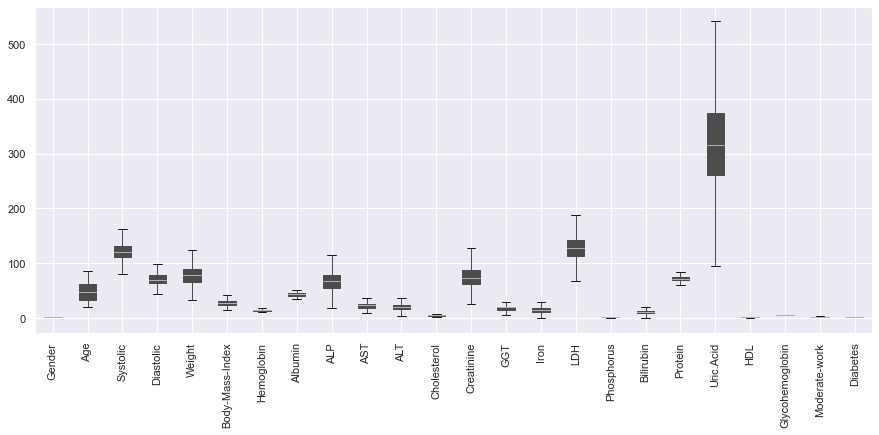

In [180]:
plt.subplots(figsize=(15,6))
X.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [181]:
for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

In [182]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [183]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(data = scaled_data, columns = X.columns)
scaled_df.head()


,Gender,Age,Systolic,Diastolic,Weight,Body-Mass-Index,Hemoglobin,Albumin,ALP,AST,...,Iron,LDH,Phosphorus,Bilirubin,Protein,Uric.Acid,HDL,Glycohemoglobin,Moderate-work,Diabetes
0,-1.026927,1.557803,-1.550529,-1.364841,-0.200522,-0.594546,-0.057520,0.726296,-0.309102,-0.790869,...,-0.630587,0.501804,-0.794259,0.243672,-0.000498,0.551461,0.177571,-2.261760,2.740933,0.0
1,-1.026927,0.003128,0.020931,1.166823,0.809160,0.228165,0.220450,0.726296,-0.252824,-0.174965,...,1.813833,0.188553,-0.989929,-0.661559,0.219406,1.070389,-0.715435,0.338547,-1.171490,0.0
2,-1.026927,-0.663161,-0.044546,2.667068,1.204766,0.525908,1.262840,1.374143,-0.252824,-1.201472,...,-0.630587,0.099053,-0.414776,-1.140799,-0.000498,0.255286,-1.003501,-0.636568,-1.171490,0.0
3,-1.026927,1.169134,0.544751,-0.427187,-0.897262,-0.463304,1.818781,-0.893321,1.998322,0.235638,...,-0.464676,2.336562,-1.754823,-0.661559,-1.319924,1.143811,-0.139302,0.013509,2.740933,0.0
4,-1.026927,1.779899,0.937616,-0.896014,-0.194617,-0.118549,1.679795,0.726296,2.392272,0.030336,...,-0.531040,0.949306,-0.989929,-0.208944,1.538832,0.626127,-0.830661,1.313662,-1.171490,0.0


In [184]:
label = data["Diabetes"]


In [185]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [186]:
X = scaled_df
y = label 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [187]:
print(X_train.shape, y_test.shape)
print(y_train.shape, y_test.shape)

(29663, 24) (7416,)
(29663,) (7416,)


In [188]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

xnew2=SelectKBest(f_classif, k=20).fit_transform(X, y)

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning:

Features [23] are constant.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



In [189]:
 import sklearn.feature_selection as fs
 import matplotlib.pyplot as plt
 df2 = fs.SelectKBest(k='all')

 df2.fit(X, y)

 names = X.columns.values[df2.get_support()]

 scores = df2.scores_[df2.get_support()]

 names_scores = list(zip(names, scores))

 ns_df = pd.DataFrame(data = names_scores, columns=

  ['Features','F_Scores'])

 ns_df_sorted = ns_df.sort_values(['F_Scores','Features'], ascending =

  [False, True])

 print(ns_df_sorted)

           Features     F_Scores
1               Age  2686.409705
5   Body-Mass-Index  1000.670115
2          Systolic   766.368625
4            Weight   526.900940
7           Albumin   525.811066
21  Glycohemoglobin   477.417483
20              HDL   378.750379
11      Cholesterol   334.923024
13              GGT   305.472574
6        Hemoglobin   271.220818
14             Iron   211.216877
22    Moderate-work   188.266414
8               ALP   156.172300
19        Uric.Acid   144.722845
12       Creatinine   102.880413
17        Bilirubin    80.463331
3         Diastolic    63.316044
15              LDH    49.826302
10              ALT    27.645892
9               AST    22.682305
0            Gender    12.219556
18          Protein     8.581358
16       Phosphorus     0.000433
23         Diabetes          NaN


C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning:

Features [23] are constant.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



In [190]:
#import statsmodels.api as sm
#import pandas
#from patsy import dmatrices
#logit_model = sm.OLS(y_train, X_train)
#result = logit_model.fit()
#print(result.summary2())

In [191]:
#np.exp(result.params)


In [192]:
#params = result.params
#conf = result.conf_int()
#conf['Odds Ratio'] = params.sort_index()
#conf.columns = ['5%', '95%', 'Odds Ratio']
#print(np.exp(conf))

In [193]:
#result.pvalues.sort_values()


In [194]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
                                                # np.unique(y_train),
                                                # y_train)
#model.fit(X_train, y_train, class_weight=class_weights)


Best parameters : {'class_weight': {0: 0.4289473684210526, 1: 0.5710526315789475}}


<AxesSubplot:xlabel='weight'>

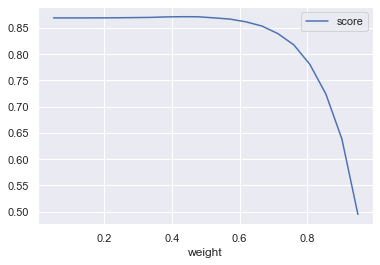

In [195]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='accuracy',
    cv=15
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [196]:
class_weight = {0: 0.5236842105263158,
                1: 0.47631578947368425}

In [197]:
#LR

In [198]:
'''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
lr = LogisticRegression(class_weight='balanced',random_state=420)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

"\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix, classification_report\nfrom mlxtend.plotting import plot_decision_regions, plot_confusion_matrix\nfrom matplotlib import pyplot as plt\nlr = LogisticRegression(class_weight='balanced',random_state=420)\n\n# Fit..\nlr.fit(X_train, y_train)\n\n# Predict..\ny_pred = lr.predict(X_test)\n\n# Evaluate the model\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred))\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n"

In [199]:
'''
from sklearn.svm import SVC

clf_svc_rbf = SVC(kernel="rbf",class_weight='balanced',random_state=4200)
clf_svc_rbf.fit(X_train,y_train)
y_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_clf_svc_rbf)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred_clf_svc_rbf))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

'\nfrom sklearn.svm import SVC\n\nclf_svc_rbf = SVC(kernel="rbf",class_weight=\'balanced\',random_state=4200)\nclf_svc_rbf.fit(X_train,y_train)\ny_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)\n\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_clf_svc_rbf)\n\n#plt.figure(figsize=(5,5))\n#sns.heatmap(cm,annot=True)\n#plt.show()\n\n#print(classification_report(y_test,y_pred_clf_svc_rbf))\n\nprint(classification_report(y_test, y_pred_clf_svc_rbf))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n'

              precision    recall  f1-score   support

           0       0.68      0.23      0.34       951
           1       0.90      0.98      0.94      6465

    accuracy                           0.89      7416
   macro avg       0.79      0.61      0.64      7416
weighted avg       0.87      0.89      0.86      7416



0.6072533247454749

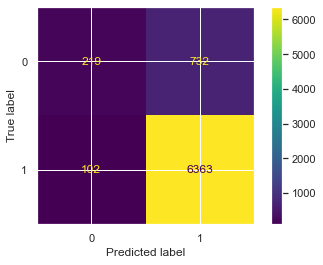

In [200]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rd = RandomForestClassifier(class_weight='balanced',random_state=4200)
rd.fit(X_train,y_train)
y_pred_rd = rd.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_rd)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True,linewidths=.3)
#plt.show()

print(classification_report(y_test,y_pred_rd))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_rd)  #added by Elena becuase of confusion matrix error 


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rd)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


In [201]:
#CV appraoach

## SVM

In [202]:

# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = SVC(kernel='rbf', C=1, class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8742 (0.0033)


array([0.87702265, 0.875     , 0.87540453, 0.87473031, 0.86933657,
       0.87769687, 0.86731392, 0.87432578, 0.87338188, 0.87823625])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of 

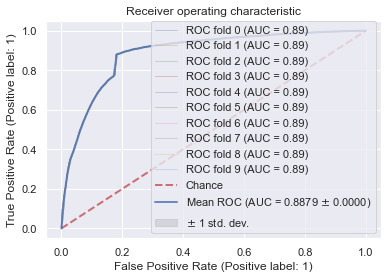

In [203]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold



# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = svm.SVC(kernel='rbf', probability=True, class_weight=class_weight,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

# LR

In [204]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = LogisticRegression(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8691 (0.0041)


array([0.87230313, 0.87149407, 0.8675836 , 0.87068501, 0.86313376,
       0.87028047, 0.8623247 , 0.87095469, 0.86637001, 0.87621359])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of 

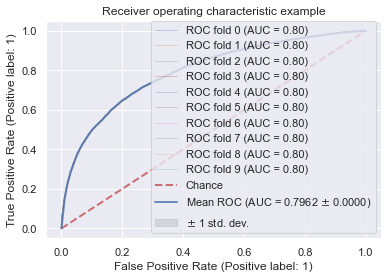

In [205]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = LogisticRegression(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

## RF

In [206]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ShuffleSplit

# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = RandomForestClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8911 (0.0029)


array([0.89279935, 0.89333873, 0.8907767 , 0.89023732, 0.88781014,
       0.89428263, 0.88592233, 0.8917206 , 0.88834951, 0.89563107])

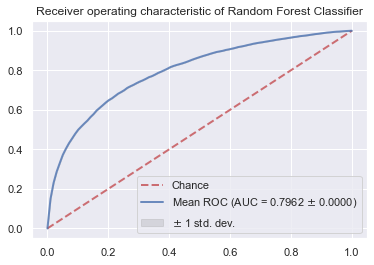

In [207]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    #viz = plot_roc_curve(classifier, X, y,
                  #       name='ROC fold {}'.format(i),
                    #     alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic of Random Forest Classifier")
ax.legend(loc="lower right")
plt.show()

## DT

In [208]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier


# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = DecisionTreeClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.8417 (0.0029)


array([0.84115426, 0.84209817, 0.84425566, 0.84263754, 0.84142395,
       0.84452535, 0.83535599, 0.84614347, 0.83980583, 0.84007551])

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

C:\Users\Eigenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of 

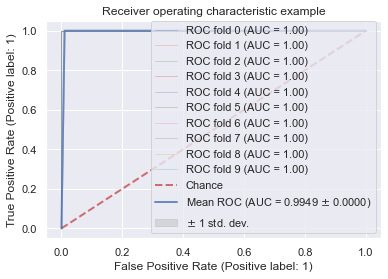

In [209]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [210]:
#from sklearn.model_selection import cross_val_score
#from sklearn import svm
#clf = svm.SVC(kernel='rbf', C=1, class_weight=class_weight)
#scores = cross_val_score(clf, X, y, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

#clf.score(X_test, y_test)

## ANN

In [211]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [212]:
classifier=Sequential()
classifier.add(Dense(units=256, kernel_initializer='uniform',activation='relu',input_dim=24))
classifier.add(Dense(units=128, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=64, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(units=32, kernel_initializer='uniform',activation='relu'))

classifier.add(Dense(units=1, kernel_initializer='uniform',activation='sigmoid'))
classifier.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
classifier.fit(X_train,y_train,batch_size=10,epochs=100,class_weight=class_weight,validation_data=(X_test, y_test))

Epoch 1/100
2967/2967 [==============================] - 11s 3ms/step - loss: 0.1614 - accuracy: 0.8719 - val_loss: 0.2987 - val_accuracy: 0.8869
Epoch 2/100
2967/2967 [==============================] - 10s 3ms/step - loss: 0.1485 - accuracy: 0.8859 - val_loss: 0.2847 - val_accuracy: 0.8888
Epoch 3/100
2967/2967 [==============================] - 9s 3ms/step - loss: 0.1425 - accuracy: 0.8900 - val_loss: 0.2721 - val_accuracy: 0.8897
Epoch 4/100
2967/2967 [==============================] - 10s 3ms/step - loss: 0.1376 - accuracy: 0.8928 - val_loss: 0.2666 - val_accuracy: 0.8927
Epoch 5/100
2967/2967 [==============================] - 10s 3ms/step - loss: 0.1344 - accuracy: 0.8935 - val_loss: 0.2730 - val_accuracy: 0.8909
Epoch 6/100
2967/2967 [==============================] - 10s 3ms/step - loss: 0.1329 - accuracy: 0.8965 - val_loss: 0.2669 - val_accuracy: 0.8892
Epoch 7/100
2967/2967 [==============================] - 10s 3ms/step - loss: 0.1315 - accuracy: 0.8968 - val_loss: 0.2627 - 

In [213]:
#clf_svc_rbf.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score
y_pred = classifier.predict(X_test)>0.9


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred))
#plot_confusion_matrix(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

232/232 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.37      0.60      0.46       951
           1       0.93      0.85      0.89      6465

    accuracy                           0.82      7416
   macro avg       0.65      0.72      0.67      7416
weighted avg       0.86      0.82      0.84      7416



0.7237839763248357

AUC Score: 0.7237839763248357


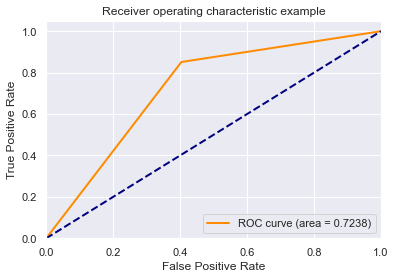

In [214]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , y_pred)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [215]:
#from sklearn.tree import DecisionTreeClassifier


#from sklearn.model_selection import cross_val_score

#dt = DecisionTreeClassifier(class_weight=class_weight)
#scores = cross_val_score(clf, X, y, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [216]:
'''

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred_logistic = lr.predict(X_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_logistic)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=.3)
plt.show()

print(classification_report(y_test,y_pred_logistic))


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
print(f1_score(y_test, y_pred_logistic,average="macro"))
'''

'\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score\n\nlr = LogisticRegression()\nlr.fit(X_train,y_train)\ny_pred_logistic = lr.predict(X_test)\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_logistic)\n\nplt.figure(figsize=(5,5))\nsns.heatmap(cm,annot=True,linewidths=.3)\nplt.show()\n\nprint(classification_report(y_test,y_pred_logistic))\n\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\nprint(f1_score(y_test, y_pred_logistic,average="macro"))\n'

In [217]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [218]:
clf1 = SVC(kernel='rbf', C=1, class_weight=class_weight,random_state=42)
clf2 = LogisticRegression(class_weight=class_weight,random_state=42)
clf3 = RandomForestClassifier(class_weight=class_weight,random_state=42)
clf4 = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
#clf5 = Sequential()

In [219]:
eclf = VotingClassifier( estimators=[('svm', clf1), ('lr', clf2), ('rf', clf3), ('dt',clf4)],
     voting='hard')

In [220]:
for clf, label in zip([clf1, clf2, clf3,clf4 ,eclf], ['SVM', 'LR', 'RF','DT', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))
scores

Accuracy: 0.8846 (+/- 0.0046) [Ensemble]


array([0.87944984, 0.88079827, 0.88187702, 0.89239482, 0.88349515,
       0.87729234, 0.88942826, 0.88888889, 0.88619202, 0.88616132])

# Additional code

In [221]:
accuracy_25_list=[]
for clf, label in zip([clf1, clf2, clf3,clf4 ,eclf], ['SVM', 'LR', 'RF','DT', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    accuracy_25_list.append("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores
print("Accuracy:", accuracy_25_list)

Accuracy: ['0.8738 (+/- 0.0016)', '0.8691 (+/- 0.0031)', '0.8909 (+/- 0.0047)', '0.8400 (+/- 0.0068)', '0.8846 (+/- 0.0046)']


In [222]:
#adding additional table to visualize accuracy for each method

import plotly.graph_objects as go
#paper_accuracy=[0.89, 0.88, 0.90, 0.86, 0.90]  #taken from the paper diabetic study, table II

method_list= ['SVM', 'LR', 'RF','DT', 'Ensemble']
trace= go.Table(header=dict(values=['Method', 'Accuracy (25 features)']),
                cells=dict(values=[method_list, accuracy_25_list]))
fig = go.Figure(data=[trace], layout=dict(autosize=False))
fig.show()

In [223]:
print(accuracy_25_list)

['0.8738 (+/- 0.0016)', '0.8691 (+/- 0.0031)', '0.8909 (+/- 0.0047)', '0.8400 (+/- 0.0068)', '0.8846 (+/- 0.0046)']
